# Statistički pregled i predviđanje ishoda 1. HRL JUG
*Berislav Jakelić*

#### 1. Učitavanje potrebnih biblioteka i postavljanje URL-a

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

url = 'https://hrs.hr/natjecanje/?natjecanje=991'

#### 2. Web scraping stranica HRS-a i upisivanje podataka u CSV datoteke
- Tablica poretka
- Statistika najboljih strijelaca
- Rezultati odigranih utakmica
- Utakmice koje slijede

In [2]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'sadrzajtbs991')))

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

target_div = soup.find('div', {'class': 'sportinfoContainer'})

if target_div:
    table = target_div.find('table')

    with open('league_table.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)

        header_row = ['#', 'Team Name', 'Games Played', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Points']
        csv_writer.writerow(header_row)

        for idx, row in enumerate(table.find_all('tr')):
            if idx == 0:
                continue

            row.find_all('td')[0].string = ''

            data_row = [idx] + [cell.text.strip().replace(':', ',') for idx, cell in enumerate(row.find_all('td')) if idx not in [1, 9]]
            csv_writer.writerow(data_row)
    
    with open('league_table.csv', 'r', newline='', encoding='utf-8') as csvfile:
        content = csvfile.read()

    content = content.replace('"', '')
    content = content.replace(',,', ',')

    with open('league_table.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csvfile.write(content)
    
    print('Scrape success!')

driver.quit()

Scrape success!


In [3]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_statistika_0')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[4]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

second_target_div = soup.find('div', {'class': 'sl-l-container'})

if second_target_div:
    second_table = soup.find('table', {'class': 'ts-w-table sl-u-margin-bottom--3'})

    with open('player_stats.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)

        header_row = ['#', 'Player', 'Team', 'Goals', 'Games Played', 'Average', '7m Goals']
        csv_writer.writerow(header_row)

        for row in second_table.find_all('tr'):
            data_row = [cell.text.strip() for cell in row.find_all('td')]
            csv_writer.writerow(data_row)

    print('Scrape success!')

driver.quit()

Scrape success!


In [4]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_reze')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[2]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

rows = soup.select('.sp_sl-c-section__body .ts-w-latest-game__row')
data_list = []

for row in rows:
    home_team = row.select_one('.ts-w-latest-game__club-name').text.strip()
    away_team = row.select('.ts-w-latest-game__club-name')[1].text.strip()

    result_str = row.select_one('.ts-w-latest-game__item--score time').text.strip()
    result = [int(val) for val in result_str.split(':')]
        
    home_goals, away_goals = result
    if home_goals > away_goals:
        match_result = 'H'
    elif home_goals < away_goals:
        match_result = 'A'
    else:
        match_result = 'D'

    datetime_info = row.select_one('.ts-w-latest-game__item--score small').text.strip()

    data_list.append([home_team, home_goals, away_goals, away_team, match_result, datetime_info])

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Home Team', 'Home Goals', 'Away Goals', 'Away Team', 'Winner', 'Datetime'])
    csv_writer.writerows(data_list)

print('Scrape success!')

driver.quit()

Scrape success!


In [5]:
chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_raspored')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[3]/a')
link.click()

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

rows = soup.select('.sp_sl-c-section__body .ts-w-latest-game__row')
data_list = []

for row in rows:
    home_team = row.select_one('.ts-w-latest-game__club-name').text.strip()
    away_team = row.select('.ts-w-latest-game__club-name')[1].text.strip()

    data_list.append([home_team, away_team])

with open('fixtures.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Home Team', 'Away Team'])
    csv_writer.writerows(data_list)

print('Scrape success!')

driver.quit()

Scrape success!


In [6]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [7]:
df_league_table = pd.read_csv('league_table.csv')

display('df_league_table')

,#,Team Name,Games Played,Wins,Draws,Losses,Goals For,Goals Against,Points
0,1,Zamet,12,11,1,0,366,288,23
1,2,Umag,12,10,0,2,373,305,20
2,3,Buzet,12,8,0,4,342,319,16
3,4,Zadar 1954,12,7,2,3,340,317,16
4,5,Rovinj,12,7,1,4,339,320,15
5,6,Ardiaei,12,7,0,5,334,326,14
6,7,Dubovac-Gaza,12,6,0,6,297,304,12
7,8,Split,12,5,1,6,328,358,11
8,9,Hrvatski dragovoljac,12,3,1,8,245,283,7
9,10,Kozala,12,2,1,9,289,331,5


In [8]:
df_player_stats = pd.read_csv('player_stats.csv')

display('df_player_stats')

,#,Player,Team,Goals,Games Played,Average,7m Goals
0,1.0,Marin Sinčić,Umag,90,12 (12),7.50,16
1,2.0,Ivan Čirjak,Zadar 1954,74,12 (12),6.17,28
2,3.0,Tomislav Bošnjak,Umag,73,12 (12),6.08,5
3,4.0,Nedjeljko Jurković,Rovinj,73,11 (10),6.64,35
4,5.0,Raul Valković,Buzet,66,11 (11),6.00,1
5,6.0,Dario Černeka,Zamet,65,12 (12),5.42,29
6,7.0,Antonio Tomaš,Kozala,65,6 (6),10.83,15
7,8.0,Sandro Samardžić,Buzet,63,12 (12),5.25,3
8,9.0,Marko Pikec,Zamet,62,12 (12),5.17,0
9,10.0,Petar Grbac,Arena-Pula,58,12 (12),4.83,20


In [9]:
df_results = pd.read_csv('results.csv')

display('df_results')

,Home Team,Home Goals,Away Goals,Away Team,Winner,Datetime
0,Kozala,23,17,Hrvatski dragovoljac,H,18.2.24.
1,Ardiaei,32,23,BM 07,H,18.2.24.
2,Zamet,34,22,Dubovac-Gaza,H,18.2.24.
3,Rovinj,31,24,Arena-Pula,H,17.2.24.
4,Umag,29,26,Zadar 1954,H,17.2.24.
...,...,...,...,...,...,...
67,BM 07,22,32,Ardiaei,A,01.10.23.
68,Hrvatski dragovoljac,26,16,Kozala,H,30.9.23.
69,Arena-Pula,26,31,Rovinj,A,30.9.23.
70,Zadar 1954,29,28,Umag,H,30.9.23.


In [10]:
df_fixtures = pd.read_csv('fixtures.csv')

display('df_fixtures')

,Home Team,Away Team
0,BM 07,Buzet
1,Zadar 1954,Kozala
2,Hrvatski dragovoljac,Rovinj
3,Ardiaei,Zamet
4,Arena-Pula,Dubovac-Gaza
5,Split,Umag
6,Zamet,Arena-Pula
7,Dubovac-Gaza,Hrvatski dragovoljac
8,Rovinj,Zadar 1954
9,Kozala,Split


#### 3. Predviđanje ishoda utakmica i proračun potrebnih podataka
- Procjena snage napada i obrane
- Predviđanje ishoda budućih utakmica pojedinačno
- Predviđanje konačnog poretka
- Provjera kvalitete algoritma

In [11]:
team_name = df_league_table['Team Name']
games_played = df_league_table['Games Played']
goals_for = df_league_table['Goals For']
goals_against = df_league_table['Goals Against']

team_goals_for = pd.DataFrame({'Team Name': team_name, 'Goals For': goals_for, 'Games Played': games_played})
team_goals_against = pd.DataFrame({'Team Name': team_name, 'Goals Against': goals_against, 'Games Played': games_played})

display('team_goals_for', 'team_goals_against')

,Team Name,Goals For,Games Played
0,Zamet,366,12
1,Umag,373,12
2,Buzet,342,12
3,Zadar 1954,340,12
4,Rovinj,339,12
5,Ardiaei,334,12
6,Dubovac-Gaza,297,12
7,Split,328,12
8,Hrvatski dragovoljac,245,12
9,Kozala,289,12


In [12]:
average_goals_for = goals_for / games_played
average_goals_against = goals_against / games_played

team_average_goals_for = pd.DataFrame({'Team Name': team_name, 'Average Goals For': average_goals_for})
team_average_goals_against = pd.DataFrame({'Team Name': team_name, 'Average Goals Against': average_goals_against})

display('team_average_goals_for', 'team_average_goals_against')

,Team Name,Average Goals For
0,Zamet,30.500000
1,Umag,31.083333
2,Buzet,28.500000
3,Zadar 1954,28.333333
4,Rovinj,28.250000
5,Ardiaei,27.833333
6,Dubovac-Gaza,24.750000
7,Split,27.333333
8,Hrvatski dragovoljac,20.416667
9,Kozala,24.083333


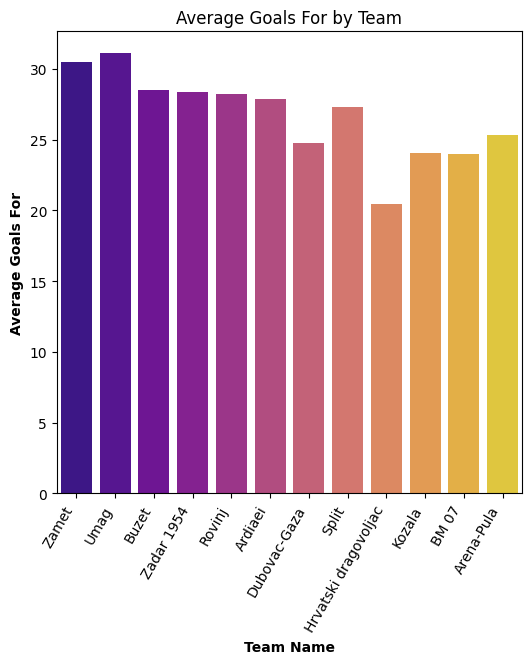

In [13]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Team Name', y='Average Goals For', data=team_average_goals_for, hue='Team Name', palette='plasma', dodge=False)
plt.title('Average Goals For by Team')
plt.xlabel('Team Name', fontweight='bold')
plt.ylabel('Average Goals For', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.show()

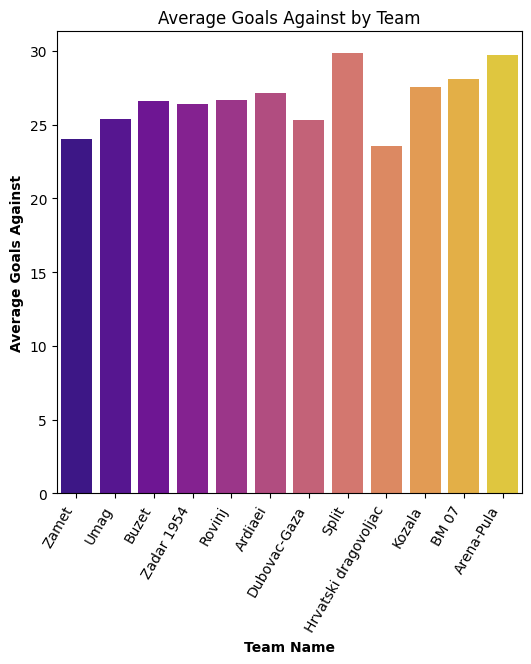

In [14]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Team Name', y='Average Goals Against', data=team_average_goals_against, hue='Team Name', palette='plasma', dodge=False)
plt.title('Average Goals Against by Team')
plt.xlabel('Team Name', fontweight='bold')
plt.ylabel('Average Goals Against', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.show()

In [15]:
bin_edges_attack = [0, 22, 23, 24, 25, 26, 27, 28, 29, 30, np.inf]
bin_labels_attack = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bin_edges_defence = [0, 22, 23, 24, 25, 26, 27, 28, 29, 30, np.inf]
bin_labels_defence = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

team_average_goals_for['Attack Power'] = pd.cut(team_average_goals_for['Average Goals For'], bins=bin_edges_attack, labels=bin_labels_attack, include_lowest=True)
team_average_goals_against['Defence Power'] = pd.cut(team_average_goals_against['Average Goals Against'], bins=bin_edges_defence, labels=bin_labels_defence, include_lowest=True)

display('team_average_goals_for', 'team_average_goals_against')

,Team Name,Average Goals For,Attack Power
0,Zamet,30.500000,10
1,Umag,31.083333,10
2,Buzet,28.500000,8
3,Zadar 1954,28.333333,8
4,Rovinj,28.250000,8
5,Ardiaei,27.833333,7
6,Dubovac-Gaza,24.750000,4
7,Split,27.333333,7
8,Hrvatski dragovoljac,20.416667,1
9,Kozala,24.083333,4


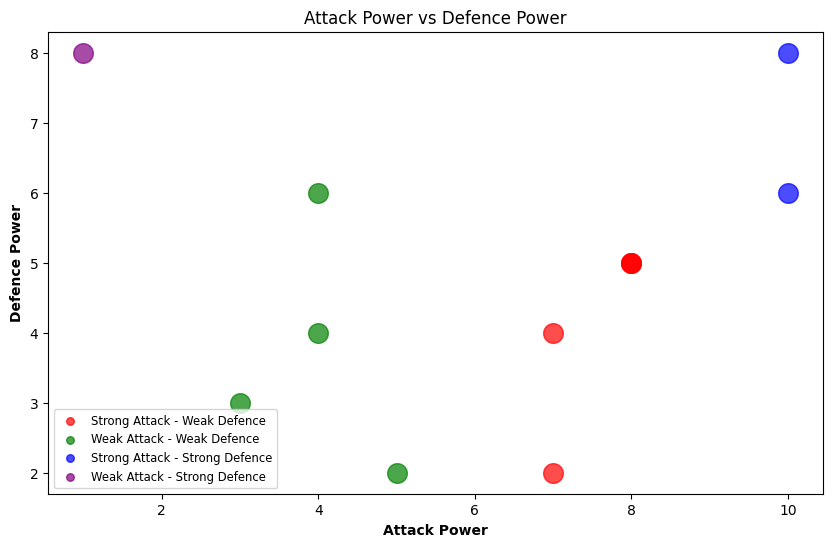

In [16]:
team_power = pd.merge(team_average_goals_for, team_average_goals_against, on='Team Name')

features = team_power[['Attack Power', 'Defence Power']]

kmeans = KMeans(n_clusters=4, random_state=42)
team_power['Cluster'] = kmeans.fit_predict(features)

cluster_names = ['Strong Attack - Weak Defence', 'Weak Attack - Weak Defence', 'Strong Attack - Strong Defence', 'Weak Attack - Strong Defence']
cluster_colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(10, 6))
for i, cluster_name in enumerate(cluster_names):
    cluster_data = team_power[team_power['Cluster'] == i]
    plt.scatter(cluster_data['Attack Power'], cluster_data['Defence Power'], label=cluster_name, color=cluster_colors[i], alpha=0.7, s=200)

plt.title('Attack Power vs Defence Power')
plt.xlabel('Attack Power', fontweight='bold')
plt.ylabel('Defence Power', fontweight='bold')
legend = plt.legend(fontsize='small')
for handle in legend.legend_handles:
    handle._sizes = [30]
plt.show()


In [17]:
team_average_goals_for['Attack Power'] = team_average_goals_for['Attack Power'].astype(float)
team_average_goals_against['Defence Power'] = team_average_goals_against['Defence Power'].astype(float)

team_overall_power = team_average_goals_for['Attack Power'] + team_average_goals_against['Defence Power']
team_overall_power = pd.DataFrame({'Team Name': team_name, 'Overall Power': team_overall_power})
display('team_overall_power')

,Team Name,Overall Power
0,Zamet,18.0
1,Umag,16.0
2,Buzet,13.0
3,Zadar 1954,13.0
4,Rovinj,13.0
5,Ardiaei,11.0
6,Dubovac-Gaza,10.0
7,Split,9.0
8,Hrvatski dragovoljac,9.0
9,Kozala,8.0


In [18]:
threshold = 0
goal_difference = df_results.groupby('Home Team')['Home Goals'].sum() - df_results.groupby('Home Team')['Away Goals'].sum()

home_bonus = pd.DataFrame({'Team Name': goal_difference.index, 'Bonus': (goal_difference > threshold).astype(float)}).reset_index(drop=True)

home_bonus.loc[home_bonus['Bonus'] == 0, 'Bonus'] = 0.5

display('home_bonus')

,Team Name,Bonus
0,Ardiaei,1.0
1,Arena-Pula,0.5
2,BM 07,0.5
3,Buzet,1.0
4,Dubovac-Gaza,1.0
5,Hrvatski dragovoljac,0.5
6,Kozala,0.5
7,Rovinj,1.0
8,Split,0.5
9,Umag,1.0


In [19]:
fixture_predictions = pd.DataFrame(columns=['Home Team', 'Away Team', 'Home Team Power', 'Away Team Power'])

merged_df = pd.merge(df_fixtures, team_overall_power, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Home Team Power'})
merged_df = pd.merge(merged_df, team_overall_power, left_on='Away Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Away Team Power'})

merged_df = pd.merge(merged_df, home_bonus, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Bonus': 'Home Bonus'})

merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']] = merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']].fillna(0)

merged_df['Home Team Power'] += merged_df['Home Bonus']

fixture_predictions['Home Team'] = merged_df['Home Team']
fixture_predictions['Away Team'] = merged_df['Away Team']
fixture_predictions['Home Team Power'] = merged_df['Home Team Power']
fixture_predictions['Away Team Power'] = merged_df['Away Team Power']

fixture_predictions['Predicted Outcome'] = 'D'
fixture_predictions.loc[merged_df['Home Team Power'] > merged_df['Away Team Power'], 'Predicted Outcome'] = 'H'
fixture_predictions.loc[merged_df['Home Team Power'] < merged_df['Away Team Power'], 'Predicted Outcome'] = 'A'

fixture_predictions.to_csv('fixture_predictions.csv', index=False)
display('fixture_predictions')


,Home Team,Away Team,Home Team Power,Away Team Power,Predicted Outcome
0,BM 07,Buzet,6.5,13.0,A
1,Zadar 1954,Kozala,14.0,8.0,H
2,Hrvatski dragovoljac,Rovinj,9.5,13.0,A
3,Ardiaei,Zamet,12.0,18.0,A
4,Arena-Pula,Dubovac-Gaza,7.5,10.0,A
5,Split,Umag,9.5,16.0,A
6,Zamet,Arena-Pula,19.0,7.0,H
7,Dubovac-Gaza,Hrvatski dragovoljac,11.0,9.0,H
8,Rovinj,Zadar 1954,14.0,13.0,H
9,Kozala,Split,8.5,9.0,A


In [20]:
team_names = pd.unique(fixture_predictions[['Home Team', 'Away Team']].values.ravel('K'))
points_prediction = pd.DataFrame({'Team Name': team_names, 'Predicted Points': 0})

for _, row in fixture_predictions.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    predicted_outcome = row['Predicted Outcome']

    if predicted_outcome == 'D':
        points_prediction.loc[points_prediction['Team Name'].isin([home_team, away_team]), 'Predicted Points'] += 1
    elif predicted_outcome == 'H':
        points_prediction.loc[points_prediction['Team Name'] == home_team, 'Predicted Points'] += 2
    elif predicted_outcome == 'A':
        points_prediction.loc[points_prediction['Team Name'] == away_team, 'Predicted Points'] += 2

display('points_prediction')

,Team Name,Predicted Points
0,BM 07,0
1,Zadar 1954,16
2,Hrvatski dragovoljac,6
3,Ardiaei,9
4,Arena-Pula,2
5,Split,6
6,Zamet,20
7,Dubovac-Gaza,11
8,Rovinj,16
9,Kozala,4


In [21]:
league_table_prediction = pd.merge(df_league_table, points_prediction, on='Team Name', how='left')

league_table_prediction[['Predicted Points']] = league_table_prediction[['Predicted Points']].fillna(0)

league_table_prediction['Total Points'] = league_table_prediction['Points'] + league_table_prediction['Predicted Points']

columns_to_drop = ['Games Played', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Points', 'Predicted Points']
league_table_prediction = league_table_prediction.drop(columns=columns_to_drop)

league_table_prediction = league_table_prediction.sort_values(by='Total Points', ascending=False)

display('league_table_prediction')

,#,Team Name,Total Points
0,1,Zamet,43
1,2,Umag,38
3,4,Zadar 1954,32
4,5,Rovinj,31
2,3,Buzet,28
5,6,Ardiaei,23
6,7,Dubovac-Gaza,23
7,8,Split,17
8,9,Hrvatski dragovoljac,13
9,10,Kozala,9


In [22]:
prev_fixtures = df_results[['Home Team', 'Away Team']].copy()

results_test = pd.DataFrame(columns=['Home Team', 'Away Team', 'Predicted Winner'])

merged_df = pd.merge(prev_fixtures, team_overall_power, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Home Team Power'})
merged_df = pd.merge(merged_df, team_overall_power, left_on='Away Team', right_on='Team Name', how='left').rename(columns={'Overall Power': 'Away Team Power'})

merged_df = pd.merge(merged_df, home_bonus, left_on='Home Team', right_on='Team Name', how='left').rename(columns={'Bonus': 'Home Bonus'})

merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']] = merged_df[['Home Team Power', 'Away Team Power', 'Home Bonus']].fillna(0)

merged_df['Home Team Power'] += merged_df['Home Bonus']

results_test['Home Team'] = merged_df['Home Team']
results_test['Away Team'] = merged_df['Away Team']
results_test['Home Team Power'] = merged_df['Home Team Power']
results_test['Away Team Power'] = merged_df['Away Team Power']

results_test['Predicted Winner'] = 'D'
results_test.loc[merged_df['Home Team Power'] > merged_df['Away Team Power'], 'Predicted Winner'] = 'H'
results_test.loc[merged_df['Home Team Power'] < merged_df['Away Team Power'], 'Predicted Winner'] = 'A'

results_test = pd.merge(results_test, df_results[['Home Team', 'Away Team', 'Winner']], on=['Home Team', 'Away Team'], how='left', suffixes=('_predicted', '_actual'))

df_comparison = results_test[['Home Team', 'Away Team', 'Winner', 'Predicted Winner']].copy()
df_comparison['Correct'] = (df_comparison['Winner'] == df_comparison['Predicted Winner']).astype(int)

correct_predictions_ratio = df_comparison['Correct'].sum() / len(df_comparison)

df_comparison.to_csv('prev_fixtures_comparison.csv', index=False)

display('df_comparison')

,Home Team,Away Team,Winner,Predicted Winner,Correct
0,Kozala,Hrvatski dragovoljac,H,A,0
1,Ardiaei,BM 07,H,H,1
2,Zamet,Dubovac-Gaza,H,H,1
3,Rovinj,Arena-Pula,H,H,1
4,Umag,Zadar 1954,H,H,1
...,...,...,...,...,...
67,BM 07,Ardiaei,A,A,1
68,Hrvatski dragovoljac,Kozala,H,H,1
69,Arena-Pula,Rovinj,A,A,1
70,Zadar 1954,Umag,H,A,0


In [23]:
print("Correct Predictions Percentage:", round(correct_predictions_ratio * 100, 2), "%")

Correct Predictions Percentage: 83.33 %


#### 4. Pregled statistike najboljih strijelaca
- Utjecaj izvođenja sedmeraca
- Utjecaj pojedinca na momčad

In [24]:
player_name = df_player_stats['Player']
goals_scored = df_player_stats['Goals']
penalties_scored = df_player_stats['7m Goals']
goals_without_penalties = goals_scored - penalties_scored

player_goals_and_penalties = pd.DataFrame({'Player': player_name, 'Goals': goals_scored, '7m Goals': penalties_scored, 'Goals from Open Play': goals_without_penalties})
display('player_goals_and_penalties')

,Player,Goals,7m Goals,Goals from Open Play
0,Marin Sinčić,90,16,74
1,Ivan Čirjak,74,28,46
2,Tomislav Bošnjak,73,5,68
3,Nedjeljko Jurković,73,35,38
4,Raul Valković,66,1,65
5,Dario Černeka,65,29,36
6,Antonio Tomaš,65,15,50
7,Sandro Samardžić,63,3,60
8,Marko Pikec,62,0,62
9,Petar Grbac,58,20,38


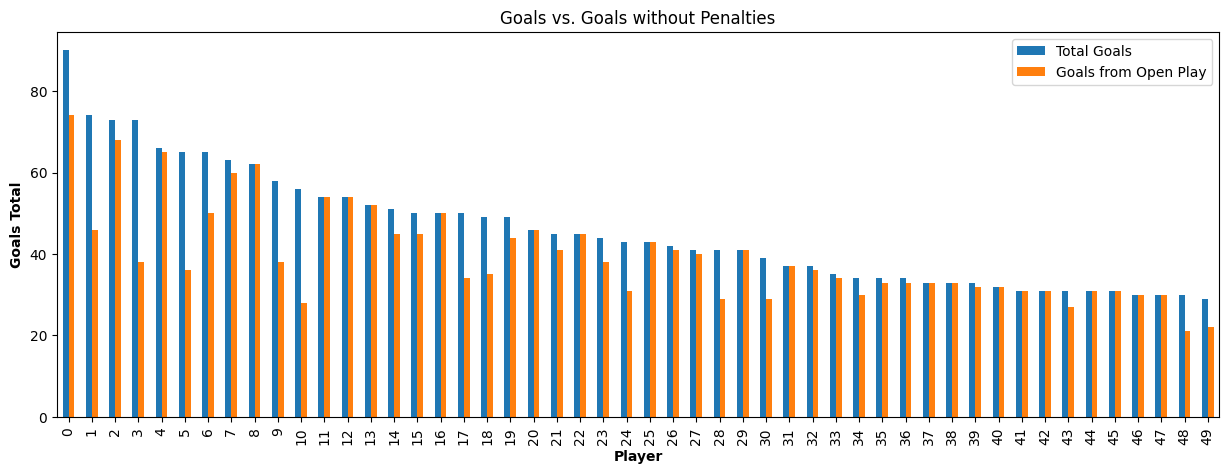

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))

player_goals_and_penalties[['Goals', 'Goals from Open Play']].plot(kind='bar', ax=ax)
plt.title('Goals vs. Goals without Penalties')
plt.xlabel('Player', fontweight='bold')
plt.ylabel('Goals Total', fontweight='bold')
plt.legend(['Total Goals', 'Goals from Open Play'])
plt.show()

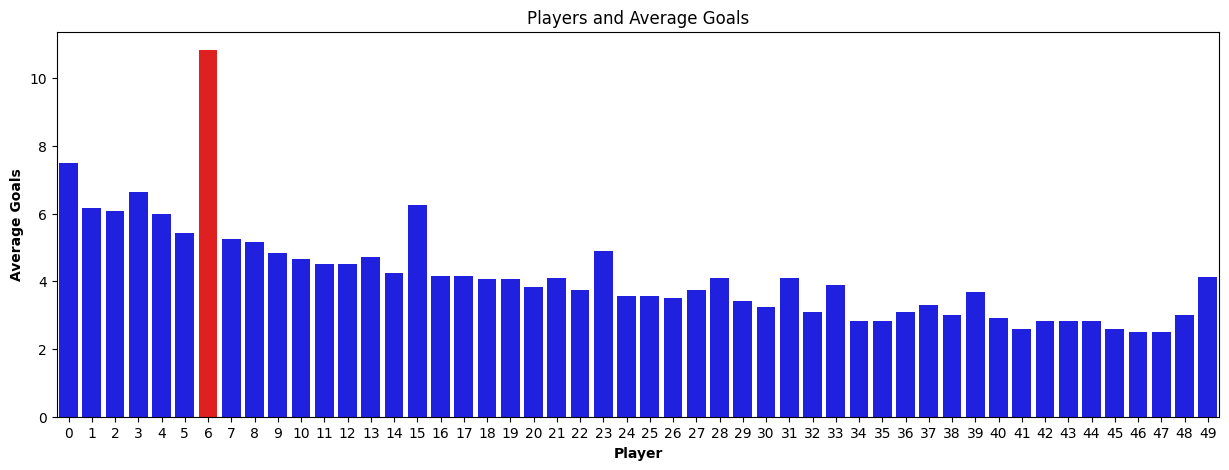

In [26]:
threshold = 8
above_threshold_color = 'red'

colors = ['red' if x > threshold else 'blue' for x in df_player_stats['Average']]

plt.figure(figsize=(15, 5))
sns.barplot(x=df_player_stats.index, y='Average', data=df_player_stats, hue='Player', palette=colors, legend=0)
plt.title('Players and Average Goals')
plt.xlabel('Player', fontweight='bold')
plt.ylabel('Average Goals', fontweight='bold')
plt.show()

In [36]:
mask_home = df_results['Home Team'] == 'Kozala'
mask_away = df_results['Away Team'] == 'Kozala'

df_tomas_kozala_home = df_results[mask_home].copy()
df_tomas_kozala_home['Opponent'] = df_tomas_kozala_home['Away Team'] + ' (H)'
df_tomas_kozala_home['Goals For'] = df_tomas_kozala_home['Home Goals']
df_tomas_kozala_home['Win or Draw'] = (df_tomas_kozala_home['Winner'].isin(['H', 'D'])).astype(int)

df_tomas_kozala_away = df_results[mask_away].copy()
df_tomas_kozala_away['Opponent'] = df_tomas_kozala_away['Home Team'] + ' (A)'
df_tomas_kozala_away['Goals For'] = df_tomas_kozala_away['Away Goals']
df_tomas_kozala_away['Win or Draw'] = (df_tomas_kozala_away['Winner'].isin(['A', 'D'])).astype(int)

df_tomas_kozala = pd.concat([df_tomas_kozala_home, df_tomas_kozala_away], ignore_index=True)

columns_to_drop = ['Home Team', 'Home Goals', 'Away Goals', 'Away Team', 'Winner', 'Datetime']
df_tomas_kozala = df_tomas_kozala.drop(columns=columns_to_drop)

display('df_tomas_kozala')

,Opponent,Goals For,Win or Draw
0,Hrvatski dragovoljac (H),23,1
1,Arena-Pula (H),34,1
2,Rovinj (H),27,1
3,Buzet (H),23,0
4,BM 07 (H),25,0
5,Zadar 1954 (H),23,0
6,Dubovac-Gaza (A),26,0
7,Zamet (A),20,0
8,Umag (A),23,0
9,Ardiaei (A),25,0


In [64]:
import time

chrome_driver_path = 'C:\\Webdrivers\\chromedriver.exe'

chrome_service = webdriver.chrome.service.Service(chrome_driver_path)
chrome_options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get(url)

WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbs991_reze')))
link = driver.find_element(By.XPATH, '/html/body/div[6]/div[2]/div/div[2]/div[1]/div/div[3]/div[1]/nav/ul/li[2]/a')
link.click()

link_elements = driver.find_elements(By.XPATH, '//a[@class="ts-w-latest-game  ts-w-latest-game--over"]')

df_temp_list = []

time.sleep(3)

for link_element in link_elements:
    team_left = link_element.find_element(By.CLASS_NAME, 'ts-w-latest-game__item--team-left').find_element(By.CLASS_NAME, 'ts-w-latest-game__club-name').text
    team_right = link_element.find_element(By.CLASS_NAME, 'ts-w-latest-game__item--team-right').find_element(By.CLASS_NAME, 'ts-w-latest-game__club-name').text
    
    if 'Kozala' in [team_left, team_right]:
        link_element.click()
        
        try:
            player_name_elements = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, 'ts-w-livescore-team__player-name'))
            )

            for player_name_element in player_name_elements:
                if 'Antonio Tomaš' in player_name_element.text:
                    opponent = [team_left, team_right]
                    if (team_left == 'Kozala'):
                        opponent.remove('Kozala')
                        opponent_name = opponent[0] + ' (H)'
                    else:
                        opponent.remove('Kozala')
                        opponent_name = opponent[0] + ' (A)'

                    next_td_element = player_name_element.find_element(By.XPATH, 'following-sibling::td')
                    goals_scored = float(next_td_element.text)

                    df_temp = pd.DataFrame({'Opponent': [opponent_name], 'Played In': [1], 'Goals Scored': [goals_scored]})
                    df_temp_list.append(df_temp)
                
        except TimeoutException:
            print(0)
        
        driver.back()

driver.quit()

if df_temp_list:
    df_temp = pd.concat(df_temp_list, ignore_index=True)

df_tomas_kozala = pd.merge(df_tomas_kozala, df_temp, on=['Opponent'], how='left')

df_tomas_kozala['Played In'].fillna(0, inplace=True)
df_tomas_kozala['Goals Scored'].fillna(0, inplace=True)

df_tomas_kozala['Played In'] = df_tomas_kozala['Played In'].astype(int)
df_tomas_kozala['Goals Scored'] = df_tomas_kozala['Goals Scored'].astype(int)

display('df_tomas_kozala')

,Opponent,Goals For,Win or Draw,Played In_x,Goals Scored_x,Played In_y,Goals Scored_y,Played In,Goals Scored
0,Hrvatski dragovoljac (H),23,1,1,10,1.0,10.0,1,10
1,Arena-Pula (H),34,1,1,8,1.0,8.0,1,8
2,Rovinj (H),27,1,1,13,1.0,13.0,1,13
3,Buzet (H),23,0,1,8,1.0,8.0,1,8
4,BM 07 (H),25,0,1,15,1.0,15.0,1,15
5,Zadar 1954 (H),23,0,0,0,NaN,NaN,0,0
6,Dubovac-Gaza (A),26,0,0,0,NaN,NaN,0,0
7,Zamet (A),20,0,0,0,NaN,NaN,0,0
8,Umag (A),23,0,0,0,NaN,NaN,0,0
9,Ardiaei (A),25,0,0,0,NaN,NaN,0,0


C:\Users\beris\AppData\Local\Temp\ipykernel_19352\3662742491.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.01928786 -0.13901715  0.14012056  0.10700663  0.01307252 -0.18309758]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_jittered.loc[mask, column] += np.random.uniform(-jitter_amount, jitter_amount, np.sum(mask))


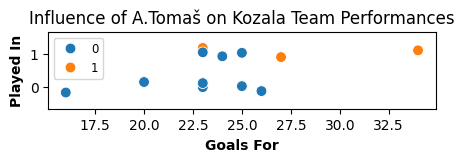

In [82]:
def add_jitter(df, column, jitter_amount):
    df_jittered = df.copy()
    
    unique_values, counts = np.unique(df[column], return_counts=True)
    overlapping_values = unique_values[counts > 1]
    for value in overlapping_values:
        mask = df[column] == value
        df_jittered.loc[mask, column] += np.random.uniform(-jitter_amount, jitter_amount, np.sum(mask))
    return df_jittered

jitter_amount = 0.2

df_tomas_kozala_jittered = add_jitter(df_tomas_kozala, 'Played In', jitter_amount)

plt.figure(figsize=(5, 1))
sns.scatterplot(x='Goals For', y='Played In', hue='Win or Draw', data=df_tomas_kozala_jittered, s=60)
plt.ylim(df_tomas_kozala_jittered['Played In'].min() - 0.5, df_tomas_kozala_jittered['Played In'].max() + 0.5)
plt.title('Influence of A.Tomaš on Kozala Team Performances')
plt.xlabel('Goals For', fontweight='bold')
plt.ylabel('Played In', fontweight='bold')
legend = plt.legend(fontsize='small', loc='upper left')
for handle in legend.legend_handles:
    handle._sizes = [10]
plt.show()

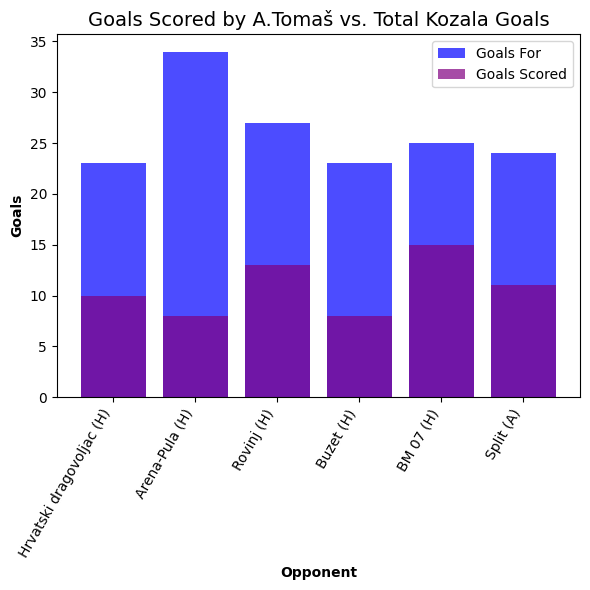

In [83]:
df_filtered = df_tomas_kozala[df_tomas_kozala['Played In'] == 1]

plt.figure(figsize=(6, 6))
plt.bar(df_filtered['Opponent'], df_filtered['Goals For'], label='Goals For', color='blue', alpha=0.7)
plt.bar(df_filtered['Opponent'], df_filtered['Goals Scored'], label='Goals Scored', color='purple', alpha=0.7)
plt.title('Goals Scored by A.Tomaš vs. Total Kozala Goals', fontsize=14)
plt.xlabel('Opponent', fontweight='bold')
plt.ylabel('Goals', fontweight='bold')
plt.xticks(rotation=60, ha='right')
plt.legend()
plt.tight_layout()
plt.show()